In [1]:
# === cell 1: imports, constants, helpers ===
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

# Config
DATA_DIR = Path("../2024_data")
FILES = [DATA_DIR / f"2024{m:02d}-bluebikes-tripdata.csv" for m in range(1, 13)]
STATION = "MIT at Mass Ave / Amherst St"
CHUNKSIZE = 500_000

usecols = ["started_at", "ended_at", "start_station_name", "end_station_name"]

# Check missing files
missing = [f for f in FILES if not f.exists()]
if missing:
    raise SystemExit(f"Missing files: {', '.join(str(f) for f in missing)}")

# Dicts to accumulate counts
out_counts = defaultdict(int)
in_counts = defaultdict(int)

def add_counts(counts, dt_series, station_mask):
    """
    Aggregates (date, hour) counts from datetime series into given dict.
    """
    tmp = pd.DataFrame({"date": dt_series.dt.date, "hour": dt_series.dt.hour})
    tmp = tmp.loc[station_mask].dropna()
    tmp["hour"] = tmp["hour"].astype(int)

    for (d, h), c in tmp.groupby(["date", "hour"]).size().items():
        counts[(d, h)] += int(c)


In [2]:
# === cell 2: build df_hourly ===

for f in FILES:
    for chunk in pd.read_csv(f, usecols=usecols, chunksize=CHUNKSIZE):
        started_dt = pd.to_datetime(chunk["started_at"], errors="coerce")
        ended_dt = pd.to_datetime(chunk["ended_at"], errors="coerce")

        add_counts(out_counts, started_dt, chunk["start_station_name"] == STATION)
        add_counts(in_counts, ended_dt,   chunk["end_station_name"]   == STATION)

df_out = pd.DataFrame(
    [(pd.to_datetime(d), h, c) for (d, h), c in out_counts.items()],
    columns=["date", "hour", "out"]
)

df_in = pd.DataFrame(
    [(pd.to_datetime(d), h, c) for (d, h), c in in_counts.items()],
    columns=["date", "hour", "in"]
)

df_hourly = (
    pd.merge(df_out, df_in, on=["date", "hour"], how="outer")
    .fillna(0)
    .sort_values(["date", "hour"])
    .reset_index(drop=True)
)

# Fill missing hours per date
all_hours = pd.MultiIndex.from_product(
    [df_hourly["date"].drop_duplicates(), range(24)],
    names=["date", "hour"],
)

df_hourly = (
    df_hourly.set_index(["date", "hour"])
    .reindex(all_hours, fill_value=0)
    .reset_index()
)

df_hourly["dow"] = df_hourly["date"].dt.dayofweek
df_hourly["month"] = df_hourly["date"].dt.month

df_hourly.head()


,date,hour,out,in,dow,month
0,2024-01-01,0,6.0,1.0,0,1
1,2024-01-01,1,0.0,1.0,0,1
2,2024-01-01,2,2.0,0.0,0,1
3,2024-01-01,3,0.0,0.0,0,1
4,2024-01-01,4,0.0,0.0,0,1


In [3]:
# === cell 3: feature engineering ===

# Days since start
min_date = df_hourly["date"].min()
df_hourly["t"] = (df_hourly["date"] - min_date).dt.days.astype(float)

# Fourier annual seasonality
period = 365.25
df_hourly["sin_annual"] = np.sin(2 * np.pi * df_hourly["t"] / period)
df_hourly["cos_annual"] = np.cos(2 * np.pi * df_hourly["t"] / period)

# Dummy variables for hour/dow/month
feature_cols = pd.get_dummies(
    df_hourly[["hour", "dow", "month"]].astype(int),
    columns=["hour", "dow", "month"],
    prefix=["h", "dow", "m"],
    drop_first=True,
).astype(float)

# Add continuous time features
feature_cols["t"] = df_hourly["t"]
feature_cols["sin_annual"] = df_hourly["sin_annual"]
feature_cols["cos_annual"] = df_hourly["cos_annual"]

# Add intercept
X_full = sm.add_constant(feature_cols)

# Target variables
y_out = df_hourly["out"].astype(float)
y_in  = df_hourly["in"].astype(float)

# Train/test split: last 7 days = test
split_date = df_hourly["date"].max() - pd.Timedelta(days=7)
train_mask = df_hourly["date"] < split_date
test_mask  = ~train_mask


In [4]:
# === cell 4: Negative Binomial GLM training ===

nb_family = sm.families.NegativeBinomial(alpha=1.0)  # alpha controls dispersion

model_out = sm.GLM(
    y_out[train_mask],
    X_full.loc[train_mask],
    family=nb_family
).fit()

model_in = sm.GLM(
    y_in[train_mask],
    X_full.loc[train_mask],
    family=nb_family
).fit()

print(model_out.summary().tables[1])
print(model_in.summary().tables[1])

# Predictions for all rows
df_hourly["out_hat"] = model_out.predict(X_full)
df_hourly["in_hat"]  = model_in.predict(X_full)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0967      0.143      0.677      0.498      -0.183       0.377
h_1           -0.4735      0.095     -4.995      0.000      -0.659      -0.288
h_2           -1.0043      0.102     -9.859      0.000      -1.204      -0.805
h_3           -1.8172      0.121    -15.074      0.000      -2.053      -1.581
h_4           -2.2063      0.134    -16.419      0.000      -2.470      -1.943
h_5           -1.8810      0.123    -15.347      0.000      -2.121      -1.641
h_6           -0.6364      0.097     -6.585      0.000      -0.826      -0.447
h_7            0.5694      0.088      6.504      0.000       0.398       0.741
h_8            1.4468      0.085     17.017      0.000       1.280       1.613
h_9            1.4069      0.085     16.534      0.000       1.240       1.574
h_10           1.4369      0.085     16.897      0.0

In [5]:
# === cell 5: MAE ===

out_mae_train = (df_hourly.loc[train_mask, "out_hat"] - df_hourly.loc[train_mask, "out"]).abs().mean()
in_mae_train  = (df_hourly.loc[train_mask, "in_hat"]  - df_hourly.loc[train_mask, "in"]).abs().mean()

out_mae_test  = (df_hourly.loc[test_mask, "out_hat"]  - df_hourly.loc[test_mask, "out"]).abs().mean()
in_mae_test   = (df_hourly.loc[test_mask, "in_hat"]   - df_hourly.loc[test_mask, "in"]).abs().mean()

print({
    "train_mae": {"out": out_mae_train, "in": in_mae_train},
    "test_mae":  {"out": out_mae_test,  "in": in_mae_test}
})


{'train_mae': {'out': np.float64(3.752503740624448), 'in': np.float64(3.9024840867058295)}, 'test_mae': {'out': np.float64(4.184836224501048), 'in': np.float64(4.268981417378684)}}


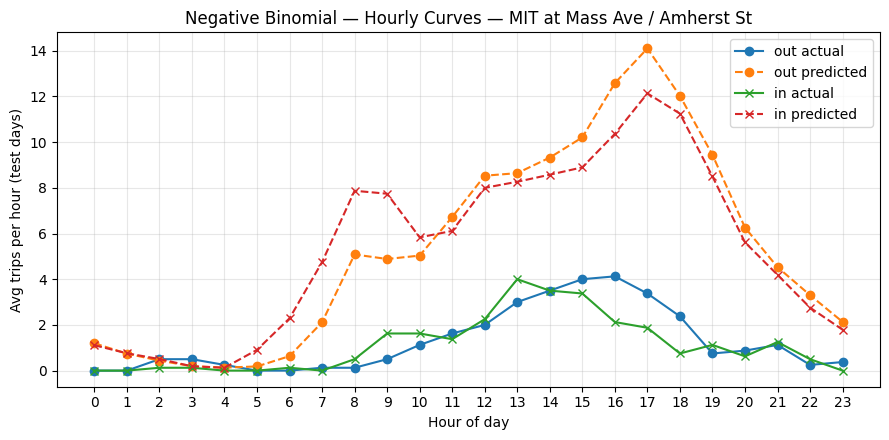

In [6]:
# === cell 6: average hourly pattern (holdout) ===

by_hour_test = (
    df_hourly.loc[test_mask]
    .groupby("hour")[["out", "out_hat", "in", "in_hat"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(9,4.5))
plt.plot(by_hour_test["hour"], by_hour_test["out"], "o-", label="out actual")
plt.plot(by_hour_test["hour"], by_hour_test["out_hat"], "o--", label="out predicted")
plt.plot(by_hour_test["hour"], by_hour_test["in"], "x-", label="in actual")
plt.plot(by_hour_test["hour"], by_hour_test["in_hat"], "x--", label="in predicted")
plt.xticks(range(24))
plt.xlabel("Hour of day")
plt.ylabel("Avg trips per hour (test days)")
plt.title(f"Negative Binomial — Hourly Curves — {STATION}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# === cell 7: helper to build X for arbitrary date ===

def build_X_for_date(d, model_columns, min_date):
    d = pd.to_datetime(d)
    hours = range(24)

    df_day = pd.DataFrame({"date": d, "hour": list(hours)})
    df_day["dow"] = df_day["date"].dt.dayofweek
    df_day["month"] = df_day["date"].dt.month

    # Time + Fourier
    df_day["t"] = (df_day["date"] - min_date).dt.days.astype(float)
    period = 365.25
    df_day["sin_annual"] = np.sin(2*np.pi*df_day["t"]/period)
    df_day["cos_annual"] = np.cos(2*np.pi*df_day["t"]/period)

    # Dummies
    X_day = pd.get_dummies(
        df_day[["hour", "dow", "month"]].astype(int),
        columns=["hour", "dow", "month"],
        prefix=["h", "dow", "m"],
        drop_first=True,
    ).astype(float)

    # Add continuous features
    X_day["t"] = df_day["t"]
    X_day["sin_annual"] = df_day["sin_annual"]
    X_day["cos_annual"] = df_day["cos_annual"]

    # Align columns
    X_day = sm.add_constant(X_day)
    X_day = X_day.reindex(columns=model_columns, fill_value=0.0)

    return df_day, X_day


def predict_for_date(d, model_out, model_in, min_date):
    df_day, X_day = build_X_for_date(d, model_out.params.index, min_date)
    df_day["out_hat"] = model_out.predict(X_day)
    df_day["in_hat"]  = model_in.predict(X_day)
    return df_day


In [8]:
# === cell 8: sanity check — two dates differ ===

p1 = predict_for_date("2024-01-01", model_out, model_in, min_date)
p2 = predict_for_date("2024-02-15", model_out, model_in, min_date)

print("max |out diff|", (p1["out_hat"] - p2["out_hat"]).abs().max())
print("max |in diff|",  (p1["in_hat"]  - p2["in_hat"]).abs().max())


max |out diff| 2.3624355869637306
max |in diff| 2.0353569608825577


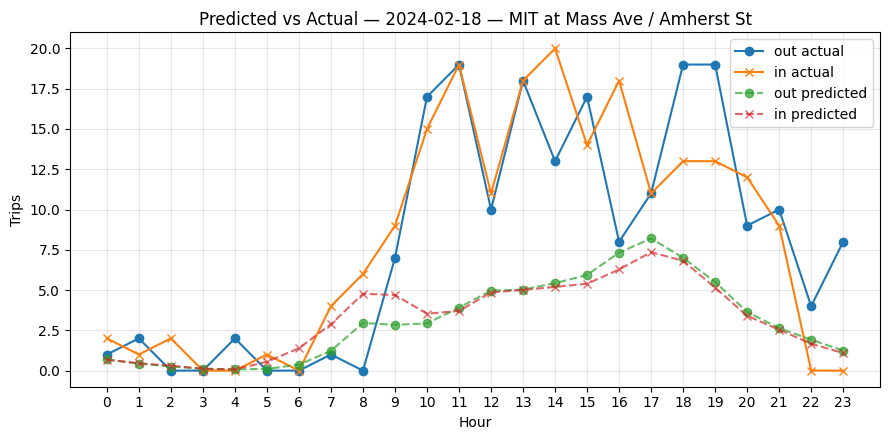

In [10]:
# === cell 9: predicted vs actual for a chosen date ===

target_date = pd.to_datetime("2024-02-18")
df_day_pred = predict_for_date(target_date, model_out, model_in, min_date)

actual_day = df_hourly[df_hourly["date"] == target_date]
has_actual = not actual_day.empty

plt.figure(figsize=(9,4.5))

if has_actual:
    plt.plot(actual_day["hour"], actual_day["out"], "o-", label="out actual")
    plt.plot(actual_day["hour"], actual_day["in"], "x-", label="in actual")

plt.plot(df_day_pred["hour"], df_day_pred["out_hat"], "o--", label="out predicted", alpha=0.7)
plt.plot(df_day_pred["hour"], df_day_pred["in_hat"],  "x--", label="in predicted",  alpha=0.7)

plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Trips")
plt.title(f"Predicted vs Actual — {target_date.date()} — {STATION}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# Convert to binary events: does at least 1 trip occur in hour?
threshold = 2.0       # you can change this!

df_hourly["out_actual_bin"] = (df_hourly["out"] >= threshold).astype(int)
df_hourly["out_pred_bin"]   = (df_hourly["out_hat"] >= threshold).astype(int)

df_hourly["in_actual_bin"] = (df_hourly["in"] >= threshold).astype(int)
df_hourly["in_pred_bin"]   = (df_hourly["in_hat"] >= threshold).astype(int)


In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate_binary(actual, pred, label="out"):
    cm = confusion_matrix(actual, pred)
    precision = precision_score(actual, pred, zero_division=0)
    recall = recall_score(actual, pred, zero_division=0)
    f1 = f1_score(actual, pred, zero_division=0)

    print(f"\n=== {label.upper()} — Classification Metrics ===")
    print("Confusion Matrix (TN, FP; FN, TP):\n", cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return cm, precision, recall, f1

# Evaluate for OUT counts
evaluate_binary(df_hourly["out_actual_bin"], df_hourly["out_pred_bin"], label="out")

# Evaluate for IN counts
evaluate_binary(df_hourly["in_actual_bin"], df_hourly["in_pred_bin"], label="in")



=== OUT — Classification Metrics ===
Confusion Matrix (TN, FP; FN, TP):
 [[1908  581]
 [ 404 5891]]
Precision: 0.9102
Recall:    0.9358
F1 Score:  0.9228

=== IN — Classification Metrics ===
Confusion Matrix (TN, FP; FN, TP):
 [[1558  642]
 [ 352 6232]]
Precision: 0.9066
Recall:    0.9465
F1 Score:  0.9261


(array([[1558,  642],
        [ 352, 6232]]),
 0.9066045970322956,
 0.9465370595382746,
 0.9261405855253381)

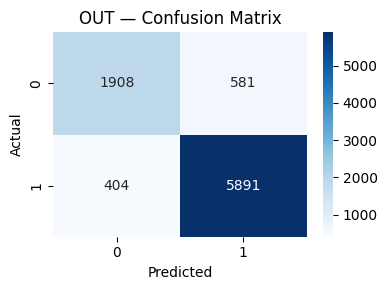

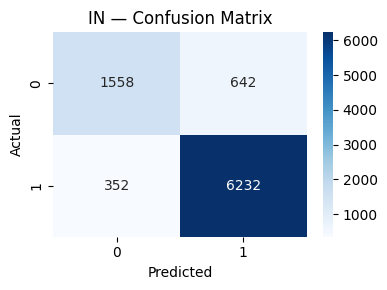

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(actual, pred, title):
    cm = confusion_matrix(actual, pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(df_hourly["out_actual_bin"], df_hourly["out_pred_bin"], "OUT — Confusion Matrix")
plot_cm(df_hourly["in_actual_bin"], df_hourly["in_pred_bin"],  "IN — Confusion Matrix")
